# 实验二: $k$-Means 算法实现消费者聚类

朱云沁 PB20061372


## Introduction

Suppose that we are given a set of data $X = \{\mathbf{x}_1, \mathbf{x}_2, \ldots, \mathbf{x}_N\}$ with each data point $\mathbf{x}_i= (x_1,x_2,\ldots,x_d)\in \mathbb{R}^d$. As a commonly-used approach of unsupervised learning, the goal of $K$-means clustering is to partition the data into $K$ clusters $\{C_1,C_2,\ldots,C_K\}$, where $C_i$ contains the data points that are closest to the $i$-th cluster center $\boldsymbol{\mu}_i$. The cluster center $\boldsymbol{\mu}_i$ is defined as the centroid of all data points in $C_i$:

$$
\boldsymbol{\mu}_i = \frac{1}{|C_i|}\sum_{\mathbf{x}\in C_i}\mathbf{x}
$$

The objective function of $K$-means clustering is to minimize the sum of squared errors (SSE) within each cluster:

$$
\min_{C_1,\ldots,C_K,\boldsymbol{\mu}_1,\ldots,\boldsymbol{\mu}_K}\sum_{i=1}^K\sum_{\mathbf{x}\in C_i}d(\mathbf{x},\boldsymbol{\mu}_i)^2
$$

where $d$ is some distance measure, e.g., the Euclidean distance. The $K$-means algorithm is an iterative procedure that alternates between updating the cluster assignment of each data point and updating the cluster centers, following the generalized expectation-maximization (GEM) framework. The pseudo-code of the $K$-means algorithm is shown below.

---

**Input:** data set $X = \{\mathbf{x}_1, \mathbf{x}_2, \ldots, \mathbf{x}_N\}$, number of clusters $K$. <br />
**Output:** cluster assignment $C_1,\ldots,C_K$ and centroids $\boldsymbol{\mu}_1,\ldots,\boldsymbol{\mu}_K$.

1. Initialize the cluster centers $\boldsymbol{\mu}_1,\ldots,\boldsymbol{\mu}_K$.
2. **while** not converged **or** maximum iterations not reached **do**
3. &emsp; **for** $i=1,\ldots,N$ **do**
4. &emsp;&emsp; $C_i \leftarrow \arg\min_{j=1,\ldots,K}d(\mathbf{x}_i,\boldsymbol{\mu}_j)$
5. &emsp; **for** $j=1,\ldots,K$ **do**
6. &emsp;&emsp; $\boldsymbol{\mu}_j \leftarrow \frac{1}{|C_j|}\sum_{\mathbf{x}\in C_j}\mathbf{x}$

---


### Evaluation Metrics

On top of the SSE objective function, we can also use the following metrics to evaluate the performance of $K$-means clustering.


#### Silhouette Coefficient

The silhouette coefficient is a measure of cluster cohesion and separation. It quantifies how well a sample is clustered with samples that are similar to itself, and how dissimilar it is from samples of other clusters.

First, we define the mean intra-cluster distance $a_i$ and the mean nearest-cluster distance $b_i$ of sample $i$ in cluster $k$ as

$$
a_i = \frac{1}{|C_k|} \sum_{\mathbf{x}_j \in C_k} d(\mathbf{x}_i, \mathbf{x}_j) \\
b_i = \min_{l \neq k} \frac{1}{|C_l|} \sum_{\mathbf{x}_j \in C_l} d(\mathbf{x}_i, \mathbf{x}_j)
$$

<!--
Alternatively, to reduce the computational complexity, we can define $a_i$ and $b_i$ as

$$
a_i = d(\mathbf{x}_i, \bm{\mu}_k) \\
b_i = \min_{l \neq k} d(\mathbf{x}_i, \bm{\mu}_l)
$$ -->

The silhouette coefficient $s_i$ for the $i$-th sample is then given by

$$
\mathrm{SC}_i = \frac{b_i - a_i}{\max\{a_i, b_i\}} \in [-1, 1]
$$

We evaluate clustering results by the mean silhouette coefficient of all samples, i.e.

$$
\mathrm{SC} = \frac{1}{N} \sum_{i=1}^N \mathrm{SC}_i
$$

With a higher silhouette coefficient, we can expect better clustering performance.


#### Calinski-Harabasz Index

The Calinski-Harabasz index also measures cluster cohesion and separation. It is defined as the ratio of the sum of extra-cluster dispersion and of intra-cluster dispersion, i.e.

$$
\mathrm{CH} = \frac{\frac{1}{K-1}\sum_{k=1}^K N_k d(\boldsymbol{\mu}_k, \boldsymbol{\mu})^2}{\frac{1}{N-K}\sum_{k=1}^K \sum_{x_i \in C_k} d(\mathbf{x}_i, \boldsymbol{\mu}_k)^2}
$$

where $\boldsymbol{\mu}$ is the global centroid of all data points, and $N_k$ is the number of data points in cluster $k$.


#### t-SNE Visualization

t-SNE is a non-linear dimensionality reduction algorithm that maps the multi-dimensional data to a low-dimensional space and attempts to preserve the local structure of the data. We demonstrate the clustering results of $K$-means on the 2-dimensional t-SNE embedding of the data points.


## Experiment


### Initialization


In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from tqdm import tqdm

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
pd.options.display.float_format = '{:.4f}'.format

### Dataset Description


#### [Abalone](https://archive.ics.uci.edu/ml/datasets/abalone)

This dataset is intended for predicting the age of abalone from physical measurements. From the original data, examples with missing values were removed, and the ranges of the continuous values have been scaled. We will use the 7 continuous attributes in this dataset (i.e. Length, Diameter, Height, Whole weight, Shucked weight, Viscera weight, Shell weight) to perform $k$-means clustering.


Length  Diameter    Height  Whole weight  Shucked weight   
count 4177.0000 4177.0000 4177.0000     4177.0000       4177.0000  \
mean     0.5240    0.4079    0.1395        0.8287          0.3594   
std      0.1201    0.0992    0.0418        0.4904          0.2220   
min      0.0750    0.0550    0.0000        0.0020          0.0010   
25%      0.4500    0.3500    0.1150        0.4415          0.1860   
50%      0.5450    0.4250    0.1400        0.7995          0.3360   
75%      0.6150    0.4800    0.1650        1.1530          0.5020   
max      0.8150    0.6500    1.1300        2.8255          1.4880   

       Viscera weight  Shell weight  
count       4177.0000     4177.0000  
mean           0.1806        0.2388  
std            0.1096        0.1392  
min            0.0005        0.0015  
25%            0.0935        0.1300  
50%            0.1710        0.2340  
75%            0.2530        0.3290  
max            0.7600        1.0050

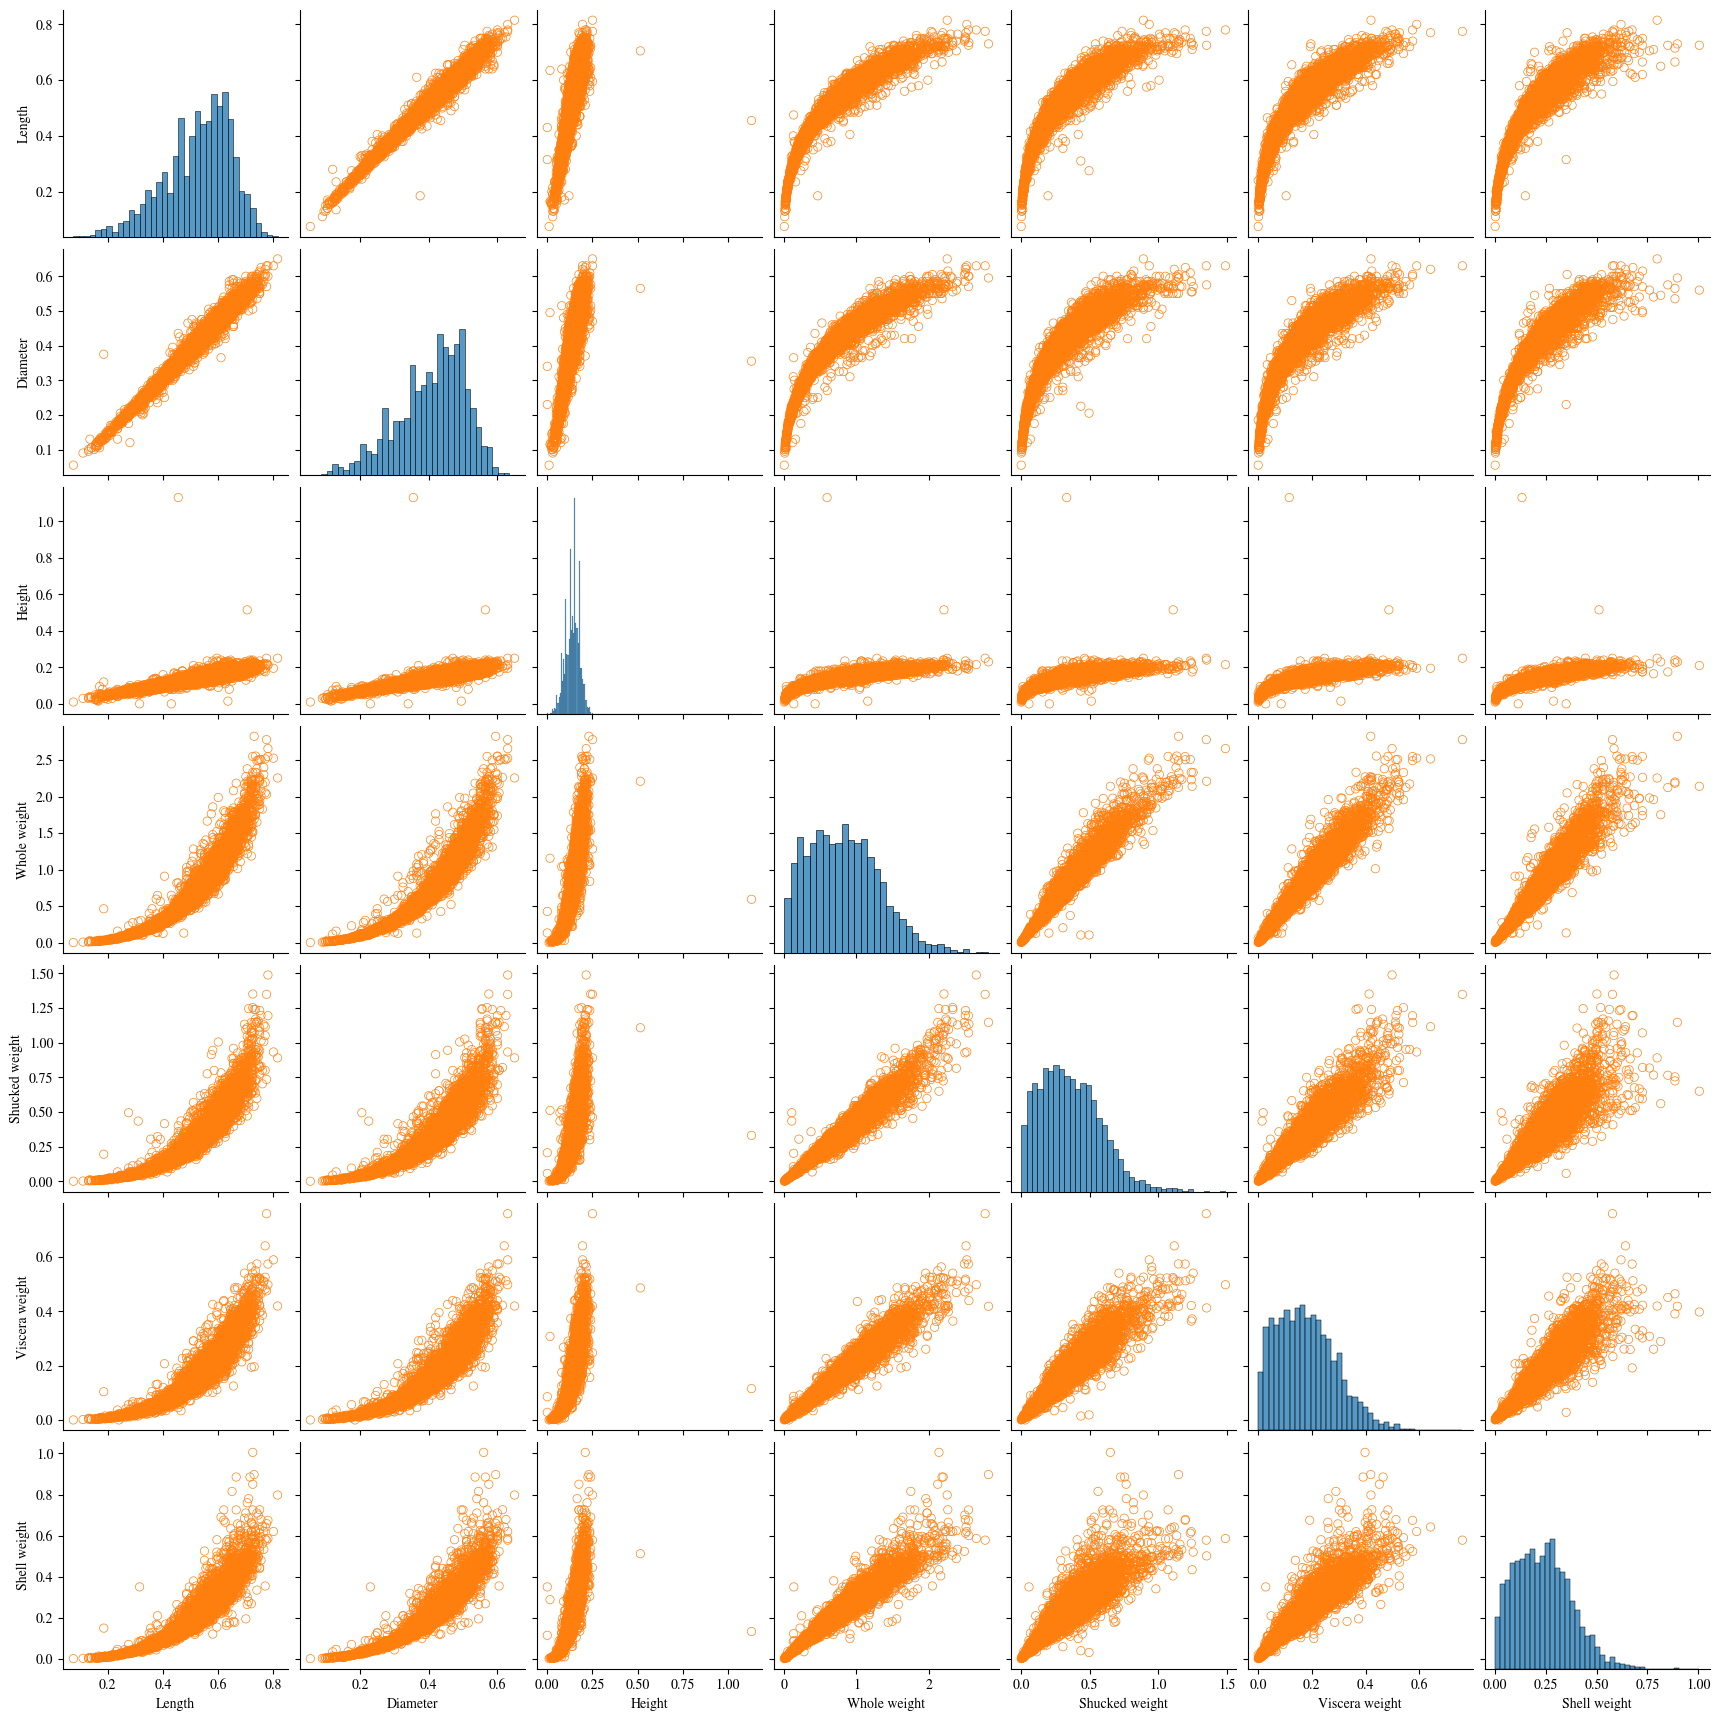

In [2]:
abalone_cols = [
    'Length',
    'Diameter',
    'Height',
    'Whole weight',
    'Shucked weight',
    'Viscera weight',
    'Shell weight',
]
abalone = pd.read_csv('abalone.csv', usecols=abalone_cols)
sns.pairplot(abalone)
abalone.describe()

#### [Concrete Compressive Strength](https://archive.ics.uci.edu/ml/datasets/Concrete+Compressive+Strength)

The concrete compressive strength is a highly nonlinear function of age and ingredients. This dataset contains 8 input attributes (i.e. Cement, Blast Furnace Slag, Fly Ash, Water, Superplasticizer, Coarse Aggregate, Fine Aggregate, Age), all of which can be viewed as continuous. We will perform $k$-means clustering after removing zero values and scaling the ranges of the attributes.


cement  blast_furnace_slag  fly_ash    water  superplasticizer   
count 225.0000            225.0000 225.0000 225.0000          225.0000  \
mean    0.0000              0.0000  -0.0000  -0.0000            0.0000   
std     1.0000              1.0000   1.0000   1.0000            1.0000   
min    -1.1107             -1.2932  -2.4011  -2.5611           -2.0541   
25%    -0.7818             -1.0704  -0.5980  -0.6740           -0.6694   
50%    -0.3421              0.1809   0.1285  -0.0591           -0.1213   
75%     0.5993              0.7448   0.6214   0.6685            0.5999   
max     2.2623              2.1864   2.0224   3.3161            3.8308   

       coarse_aggregate  fine_aggregate       age  
count          225.0000         225.0000 225.0000  
mean            -0.0000           0.0000   0.0000  
std              1.0000           1.0000   1.0000  
min             -1.6806          -2.4555  -1.1817  
25%             -0.8464          -0.7422  -0.7187  
50%             -0.0529           0.1556  -0.1293  
75%              0.7648           0.6542  -0.1293  
max              1.7122           2.1362   2.9017

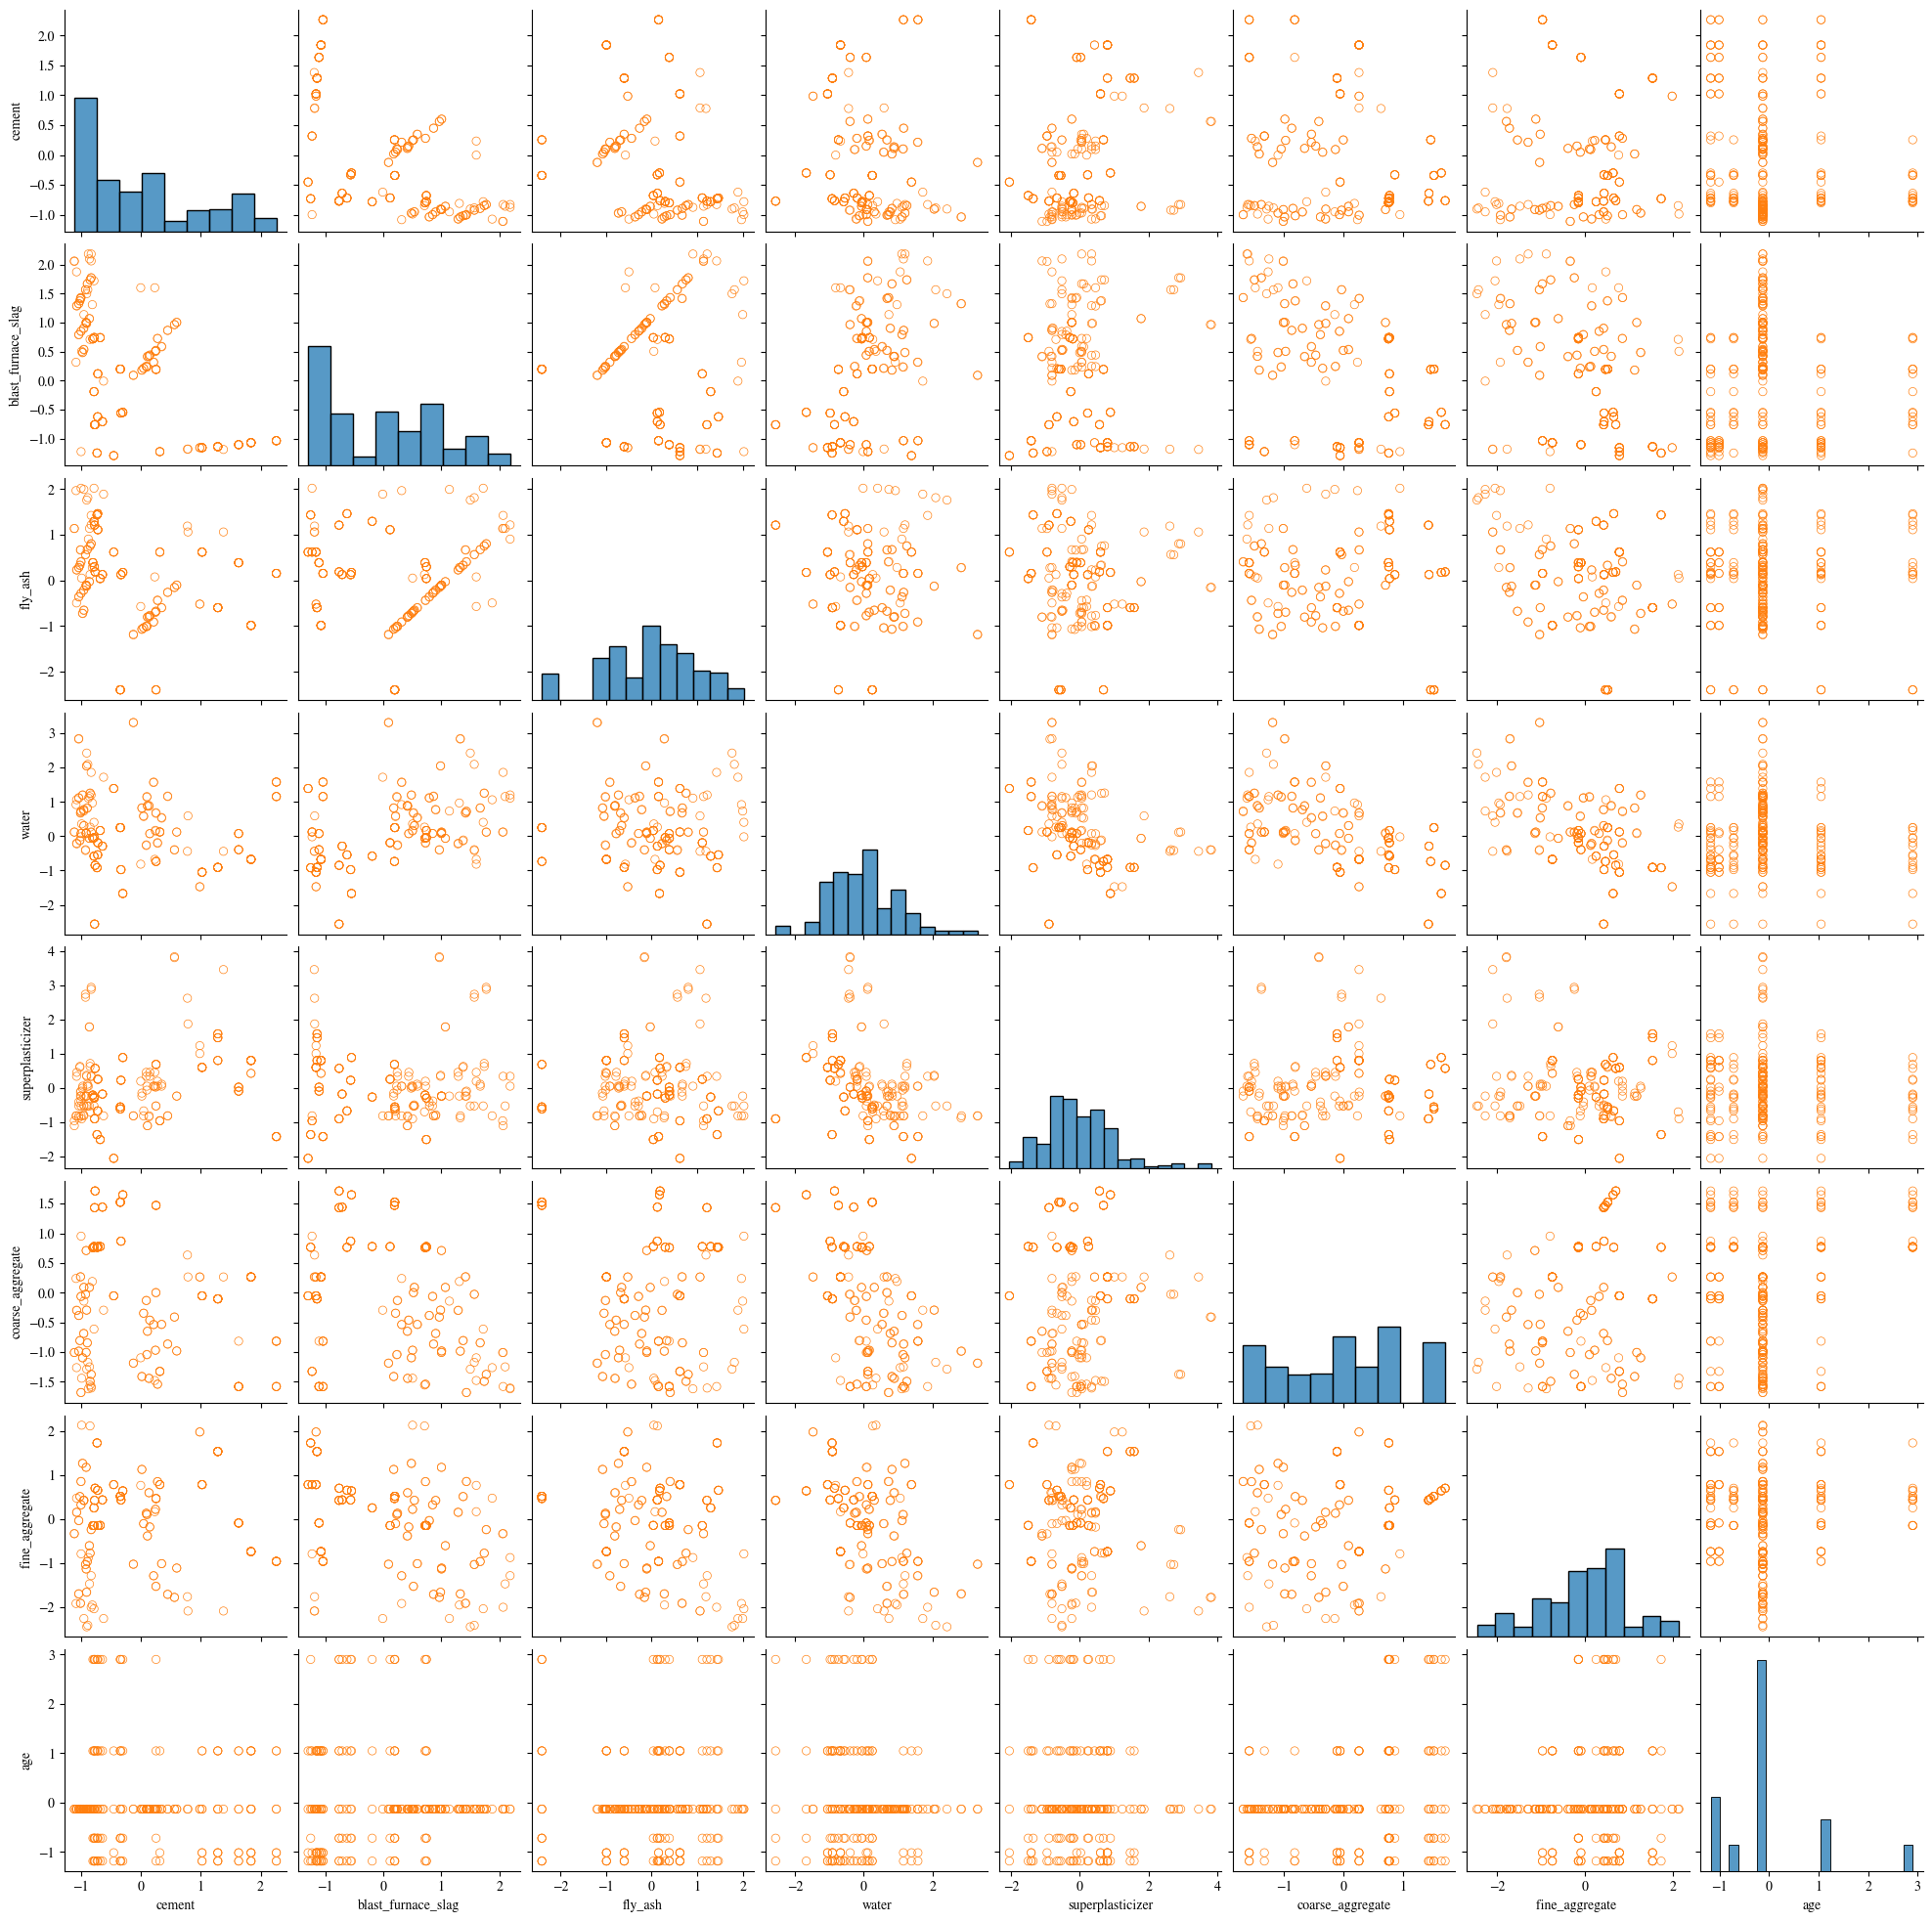

In [3]:
concrete_cols = [
    'cement',
    'blast_furnace_slag',
    'fly_ash',
    'water',
    'superplasticizer',
    'coarse_aggregate',
    'fine_aggregate ',
    'age',
]
concrete = pd.read_csv('concrete_data.csv', usecols=concrete_cols)
concrete.replace(0, np.nan, inplace=True)
concrete.dropna(inplace=True)
concrete = (concrete - concrete.mean()) / concrete.std()
sns.pairplot(concrete)
concrete.describe()

#### [California Housing](http://lib.stat.cmu.edu/datasets/houses.zip)

The data pertains to the houses found in a given California district and some summary stats about them based on the 1990 census data. The dataset provided has been filtered and preprocessed. We will use all columns exclude the target variable (i.e. MedHouseVal) to perform $k$-means clustering after scaling the ranges of the attributes.


MedInc  HouseAge  AveRooms  AveBedrms  Population  AveOccup   
count 1000.0000 1000.0000 1000.0000  1000.0000   1000.0000 1000.0000  \
mean     0.0000    0.0000    0.0000    -0.0000     -0.0000   -0.0000   
std      1.0000    1.0000    1.0000     1.0000      1.0000    1.0000   
min     -1.8412   -2.1452   -1.7713    -1.0152     -1.3197   -1.8828   
25%     -0.7130   -0.8494   -0.5237    -0.2307     -0.5745   -0.6404   
50%     -0.1480    0.0415   -0.0778    -0.1150     -0.2384   -0.1430   
75%      0.4920    0.6895    0.3659     0.0240      0.2703    0.4462   
max      5.9330    1.9044   17.1264    22.1816      7.9400    7.8119   

       Latitude  Longitude  
count 1000.0000  1000.0000  
mean    -0.0000     0.0000  
std      1.0000     1.0000  
min     -1.4122    -2.4383  
25%     -0.7579    -1.0929  
50%     -0.6232     0.5328  
75%      1.0475     0.7621  
max      3.0862     2.0463

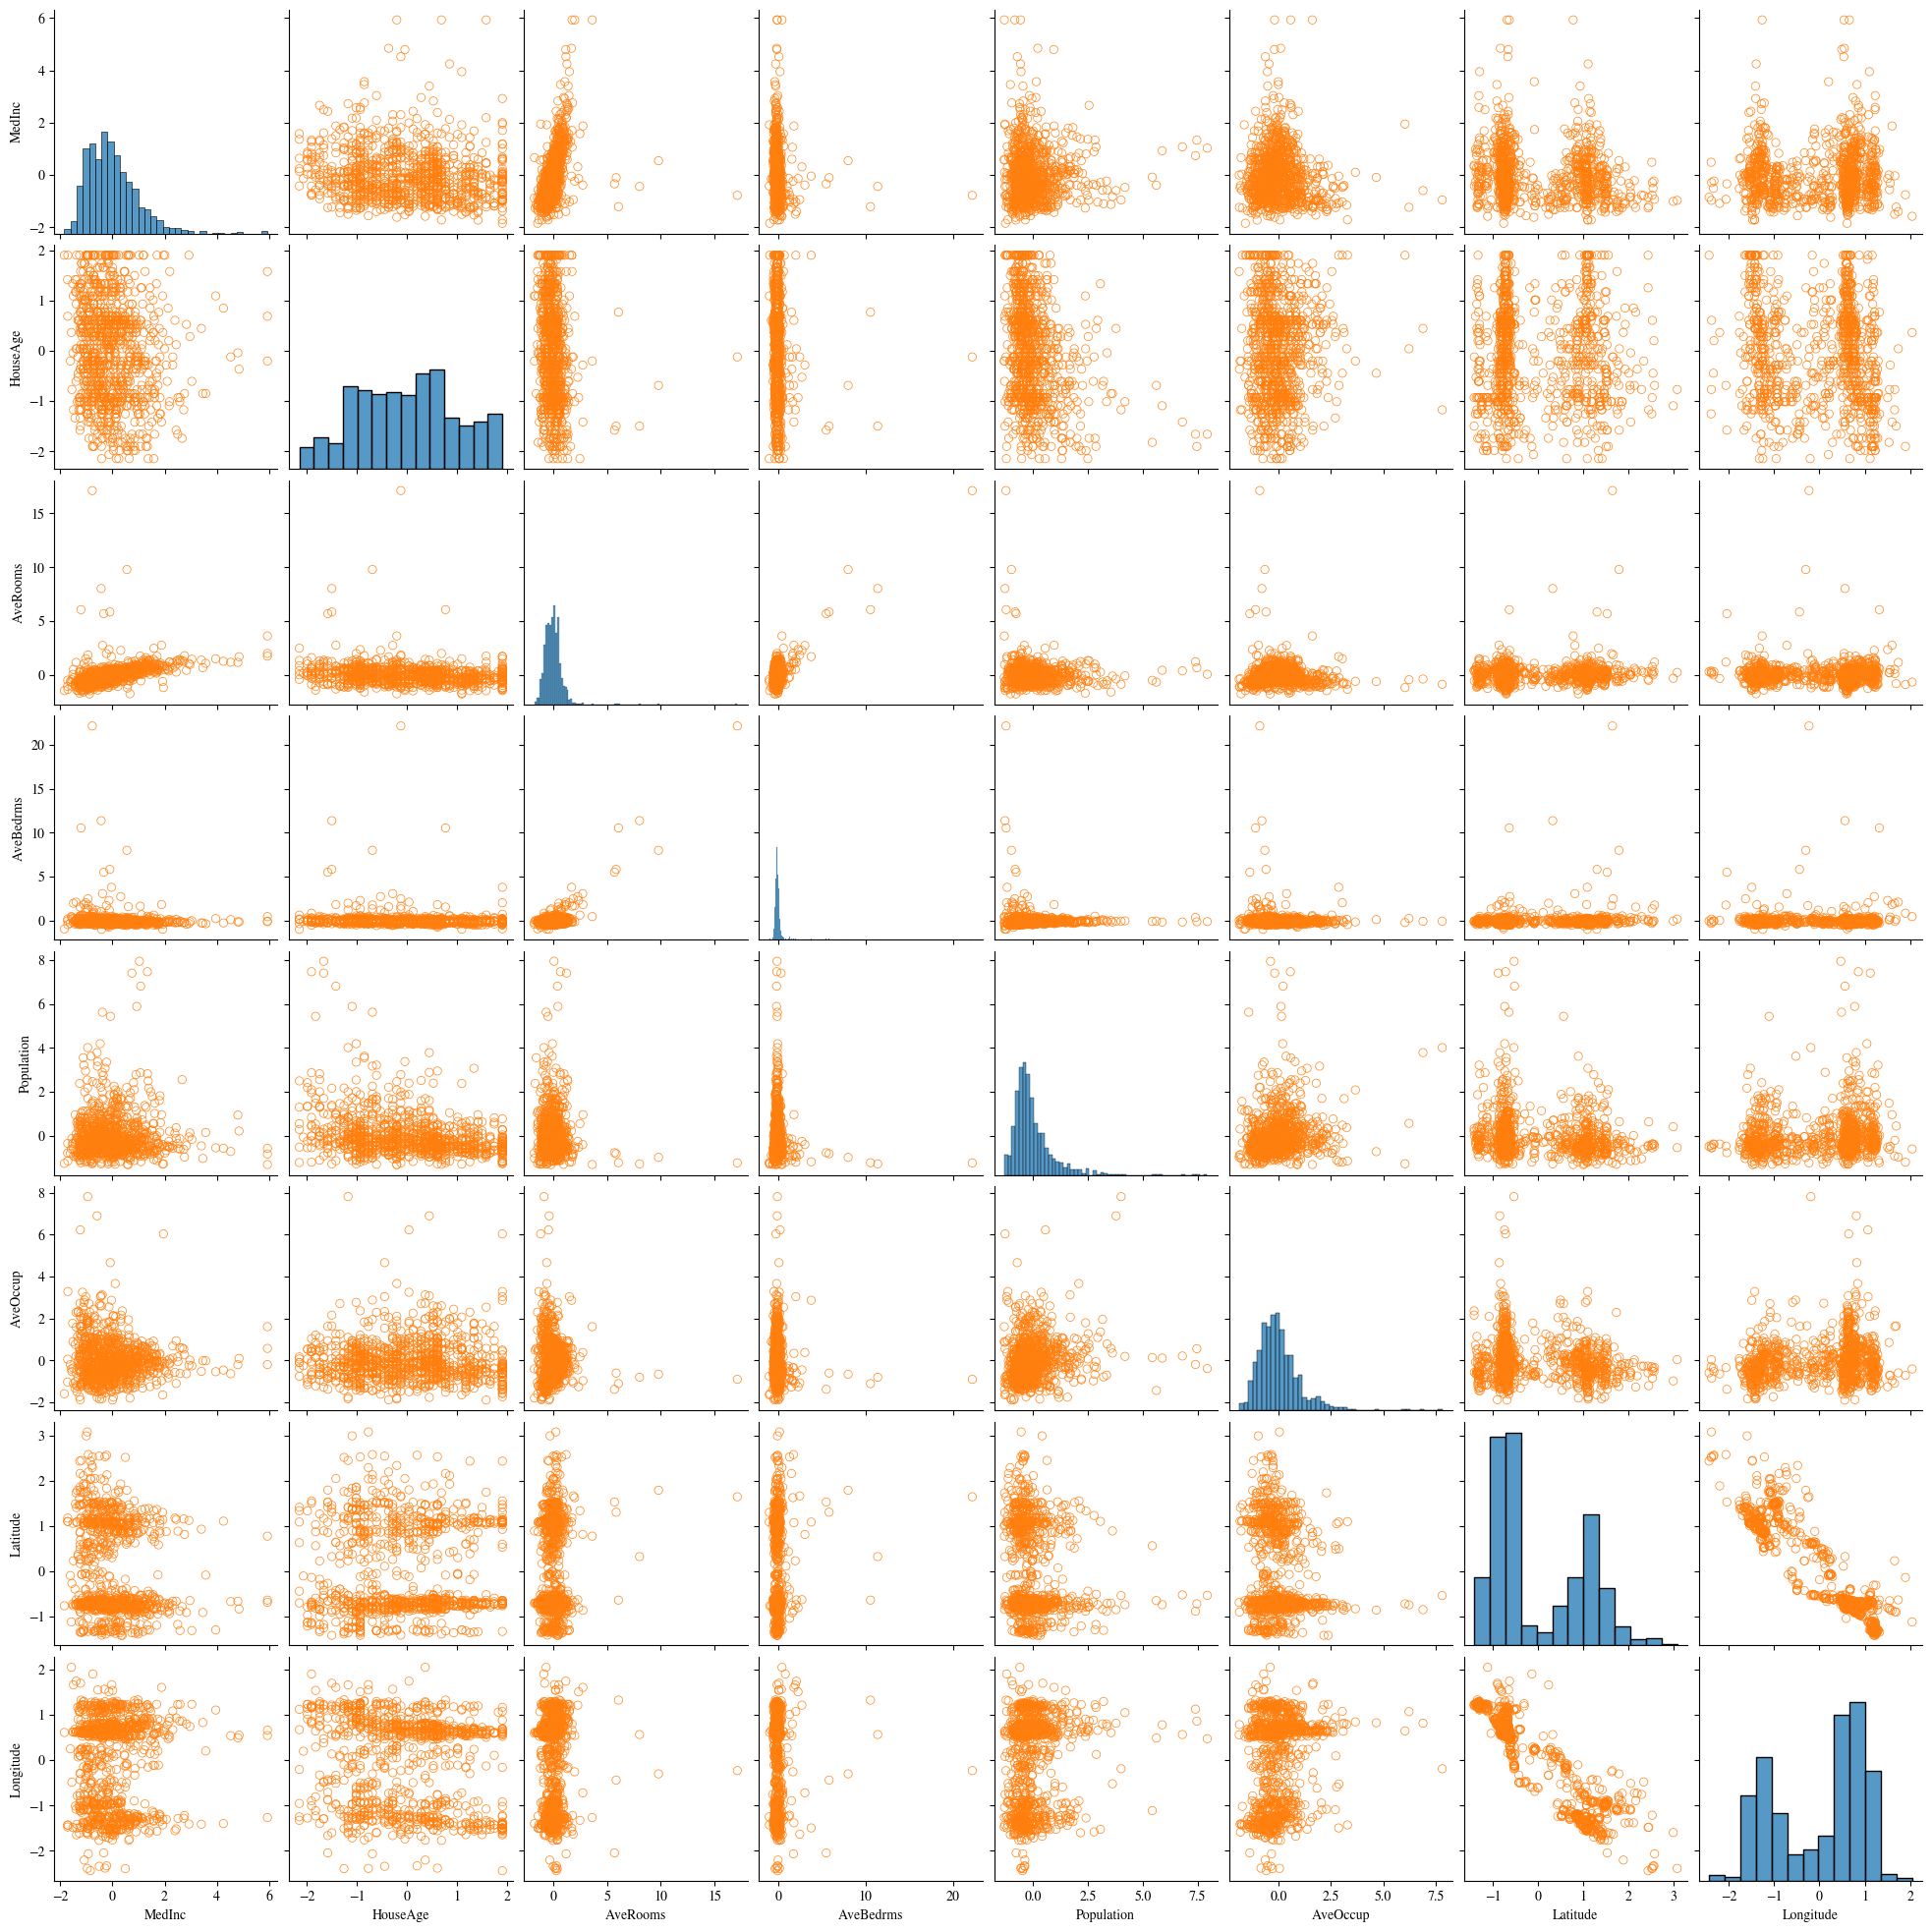

In [4]:
housing_cols = [
    'MedInc',
    'HouseAge',
    'AveRooms',
    'AveBedrms',
    'Population',
    'AveOccup',
    'Latitude',
    'Longitude',
]
housing = pd.read_csv('housing.csv', usecols=housing_cols)
housing = (housing - housing.mean()) / housing.std()
sns.pairplot(housing)
housing.describe()

#### [Mall Customer Segmentation](https://www.kaggle.com/datasets/vjchoudhary7/customer-segmentation-tutorial-in-python)

This dataset is intended for customer segmentation task based on attributes Gender, Age, Annual Income (k\\$) and Spending Score (1-100). In this experiment, we will use the last 2 numerical attributes to perform $k$-means clustering.


Annual Income (k$)  Spending Score (1-100)
count            200.0000                200.0000
mean              60.5600                 50.2000
std               26.2647                 25.8235
min               15.0000                  1.0000
25%               41.5000                 34.7500
50%               61.5000                 50.0000
75%               78.0000                 73.0000
max              137.0000                 99.0000

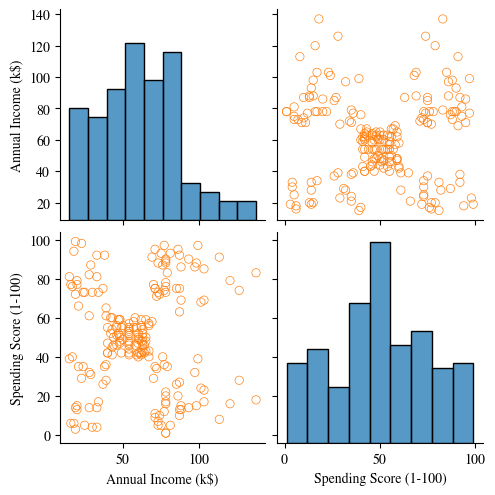

In [5]:
mall_cols = ['Annual Income (k$)', 'Spending Score (1-100)']
mall = pd.read_csv('Mall_Customers.csv', usecols=mall_cols)
sns.pairplot(mall)
mall.describe()

### Using the Scikit-Learn Library


Abalone, K = 4
Sum of Squared Errors: 173.2145
Silhouette Coefficient: 0.4889
Calinski-Harabasz Index: 10257.4543
t-SNE visualization:


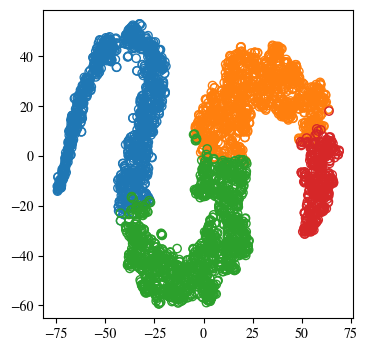

Concrete Compressive Strength, K = 4
Sum of Squared Errors: 1064.7183
Silhouette Coefficient: 0.2496
Calinski-Harabasz Index: 50.3198
t-SNE visualization:


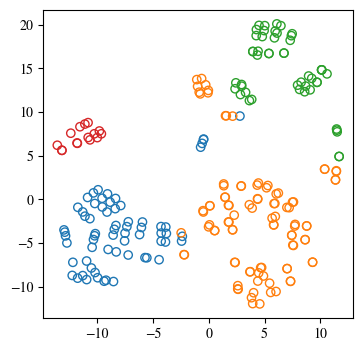

California Housing, K = 2
Sum of Squared Errors: 6213.1491
Silhouette Coefficient: 0.2845
Calinski-Harabasz Index: 285.7316
t-SNE visualization:


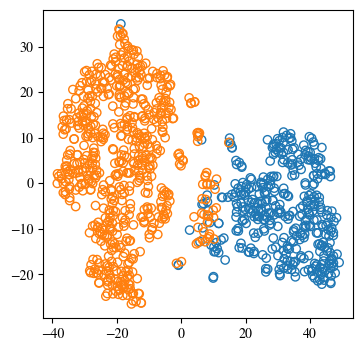

Mall Custormer Segmentation, K = 5
Sum of Squared Errors: 44448.4554
Silhouette Coefficient: 0.5539
Calinski-Harabasz Index: 247.3590
t-SNE visualization:


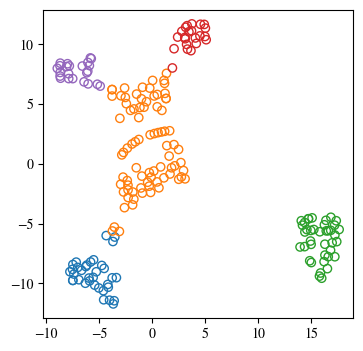

In [6]:
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE


def sum_of_squared_errors(data, labels, centroids):
    k = len(centroids)
    sse = 0
    for i in range(k):
        sse += ((data[labels == i] - centroids[i]) ** 2).sum()
    return sse


def silhouette_coefficient(data, labels, centroids):
    k = len(np.unique(labels))
    n = len(data)

    freqs = np.bincount(labels).reshape(-1, 1)
    intra = np.zeros(n)
    inter = np.zeros(n)
    for i in range(n):
        label = labels[i]
        other_labels = [*range(label), *range(label + 1, k)]
        distances = np.sqrt(((data[i] - data) ** 2).sum(axis=1))
        intra[i] = distances[labels == label].sum() / (freqs[label] - 1)
        inter[i] = np.min(
            [distances[labels == j].sum() / freqs[j] for j in other_labels]
        )

    # distances = np.sqrt(((data - centroids[:, np.newaxis]) ** 2).sum(axis=2))
    # intra = distances[labels, np.arange(n)]
    # distances[labels, np.arange(n)] = np.inf
    # inter = distances.min(axis=0)

    return np.mean((inter - intra) / np.maximum(inter, intra))


def calinski_harabasz_index(data, labels, centroids):
    k = len(np.unique(labels))
    n = len(data)
    global_centroid = data.mean(axis=0)
    freqs = np.bincount(labels).reshape(-1, 1)
    extra = (freqs * ((centroids - global_centroid) ** 2)).sum()
    intra = np.sum([((data[labels == i] - centroids[i]) ** 2).sum() for i in range(k)])
    return (extra / (k - 1)) / (intra / (n - k))


def tSNE(data, labels):
    k = len(np.unique(labels))
    tsne = TSNE(n_components=2)
    data_2d = tsne.fit_transform(data)
    plt.figure(figsize=(4, 4))
    for i in range(k):
        plt.scatter(data_2d[labels == i, 0], data_2d[labels == i, 1])
    plt.show()


def evaluate(data, labels, centroids):
    sse = sum_of_squared_errors(data, labels, centroids)
    sc = silhouette_coefficient(data, labels, centroids)
    ch = calinski_harabasz_index(data, labels, centroids)
    print(f'Sum of Squared Errors: {sse:.4f}')
    print(f'Silhouette Coefficient: {sc:.4f}')
    print(f'Calinski-Harabasz Index: {ch:.4f}')
    print(f't-SNE visualization:')
    tSNE(data, labels)


def run_sklearn_experiment(data, k):
    kmeans = KMeans(n_clusters=k, n_init=1, max_iter=100, random_state=0)
    kmeans.fit(data)
    labels = kmeans.labels_
    centroids = kmeans.cluster_centers_
    evaluate(data.values, labels, centroids)


print('Abalone, K = 4')
run_sklearn_experiment(abalone, 4)
print('Concrete Compressive Strength, K = 4')
run_sklearn_experiment(concrete, 4)
print('California Housing, K = 2')
run_sklearn_experiment(housing, 2)
print('Mall Custormer Segmentation, K = 5')
run_sklearn_experiment(mall, 5)

### Implementation of $k$-Means Clustering


Abalone, K = 4
Sum of Squared Errors: 173.2002
Silhouette Coefficient: 0.4884
Calinski-Harabasz Index: 10252.1715
t-SNE visualization:


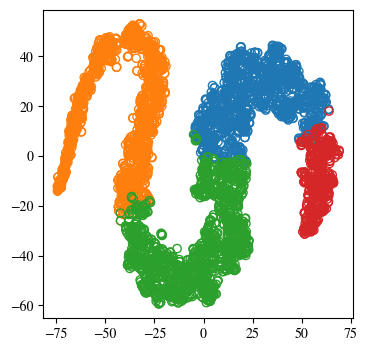

Concrete Compressive Strength, K = 4
Sum of Squared Errors: 1078.5670
Silhouette Coefficient: 0.2419
Calinski-Harabasz Index: 48.7278
t-SNE visualization:


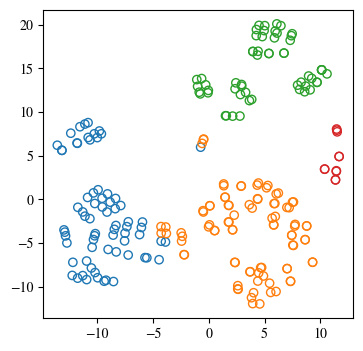

California Housing, K = 2
Sum of Squared Errors: 6213.1491
Silhouette Coefficient: 0.2845
Calinski-Harabasz Index: 285.7316
t-SNE visualization:


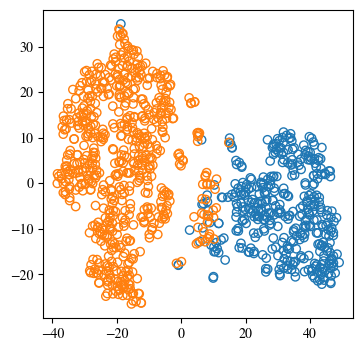

Mall Custormer Segmentation, K = 5
Sum of Squared Errors: 44454.4765
Silhouette Coefficient: 0.5532
Calinski-Harabasz Index: 247.3189
t-SNE visualization:


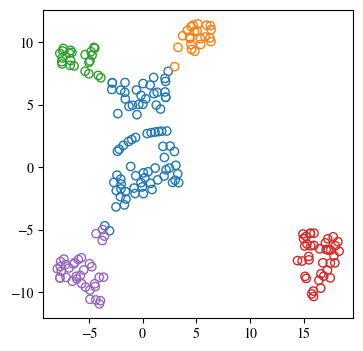

In [7]:
def kmeans(data, k, seed=42):
    np.random.seed(seed)
    centroids = data[np.random.choice(data.shape[0], k, replace=False)]
    for i in range(100):
        distances = np.sqrt(((data - centroids[:, np.newaxis]) ** 2).sum(axis=2))
        labels = np.argmin(distances, axis=0)
        centroids = np.array([data[labels == i].mean(axis=0) for i in range(k)])
    return labels, centroids


def run_numpy_experiment(data, k):
    data = data.values
    labels, centroids = kmeans(data, k)
    evaluate(data, labels, centroids)


print('Abalone, K = 4')
run_numpy_experiment(abalone, 4)
print('Concrete Compressive Strength, K = 4')
run_numpy_experiment(concrete, 4)
print('California Housing, K = 2')
run_numpy_experiment(housing, 2)
print('Mall Custormer Segmentation, K = 5')
run_numpy_experiment(mall, 5)

As can be seen from the above metrics and plots, our implementation is able to achieve comparable performance to the Scikit-Learn library.


### Time Complexity

Finding the optimal solution to the $k$-means clustering problem for $n$ observations in $\mathbb{R}^d$ is NP-hard. If $k$ and $d$ are fixed, the problem can be exactly solved in time $O(n^{dk+1})$. The iterative algorithm we use in this experiment is not guaranteed to converge to the global optimum. However, its time complexity is only $O(nkd)$ per iteration, and the number of iterations until convergence is often small on a dataset that does have a clustering structure, which makes the computation tractable.

To show that the running time is linear in $n$ and $d$, we take subsets of the Abalone dataset with different sizes and dimensions, and report the running time of $k$-means clustering with $k=3$.


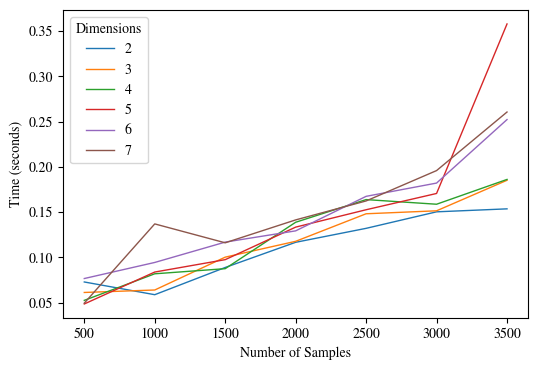

In [8]:
import timeit
import itertools

results = []
for n, d in itertools.product(range(500, 4000, 500), range(2, 8)):
    data = abalone.values[:n, :d]
    seconds = timeit.timeit(lambda: kmeans(data, 3), number=10)
    # print(f'n = {n}, d = {d}, Time: {seconds:.4f} seconds')
    results.append({'n': n, 'd': d, 'seconds': seconds})

results = pd.DataFrame(results)
plt.figure(figsize=(6, 4))
sns.lineplot(x='n', y='seconds', hue='d', data=results, palette='tab10')
plt.legend(title='Dimensions')
plt.xlabel('Number of Samples')
plt.ylabel('Time (seconds)')
plt.show()

### Effect of Initialization

The results of $k$-means clustering are highly dependent on the initialization of the cluster centers. To demonstrate this point, we randomly select 4 data points from the Concrete Compressive Strength dataset as the initial cluster centers and repeat the experiments 8 times with different random seeds.


Seed: 0    Silhouette: 0.2052
Seed: 1    Silhouette: 0.2358
Seed: 2    Silhouette: 0.2138
Seed: 3    Silhouette: 0.2192
Seed: 4    Silhouette: 0.2256
Seed: 5    Silhouette: 0.1689
Seed: 6    Silhouette: 0.2272
Seed: 7    Silhouette: 0.2364


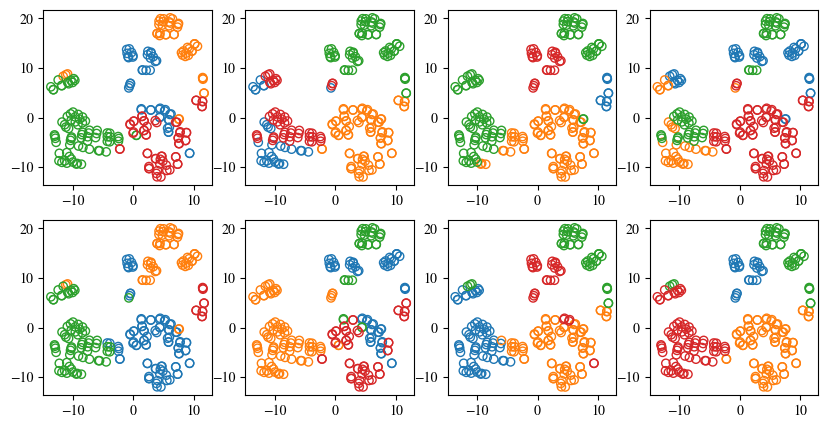

In [9]:
k = 4
data = concrete.values
tsne = TSNE(n_components=2)
data_2d = tsne.fit_transform(data)
plt.figure(figsize=(10, 5))
for i in range(8):
    plt.subplot(2, 4, i + 1)
    labels, centroids = kmeans(data, k, seed=i)
    for j in range(k):
        plt.scatter(data_2d[labels == j, 0], data_2d[labels == j, 1])
    print(
        f'Seed: {i:<4} Silhouette: {silhouette_coefficient(data, labels, centroids):.4f}'
    )
plt.show()

Another well-known initialization method is $k$-means++: The first cluster center is chosen uniformly at random from the data points that are being clustered, after which each subsequent cluster center is chosen from the remaining data points with probability proportional to its squared distance from the point's closest existing cluster center. We omit its implementation here.


### Effect of Number of Clusters

Many clustering algorithms require the number of clusters to be specified, including $k$-means. Intuitively, the optimal choice of k will strike a balance between maximum compression of the data using a single cluster, and maximum accuracy by assigning each data point to its own cluster.

The elbow method is a heuristic for determining the optimal number of clusters. Basically, we first plot the explained variation as a function of the number of clusters, and the location of a bend (knee/elbow) in the plot is considered as an indicator of the appropriate number of clusters. There are various measures of explained variation, among which we simply choose the SSE.

We use the Mall Customer Segmentation dataset to show the above process.


Text(6, 73880.64496247197, 'Elbow')

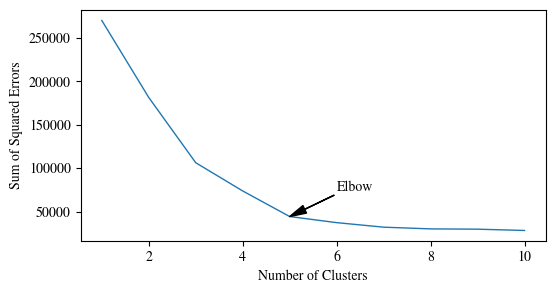

In [10]:
data = mall.values
sse = []
for k in range(1, 11):
    labels, centroids = kmeans(data, k)
    sse.append(sum_of_squared_errors(data, labels, centroids))
plt.figure(figsize=(6, 3))
plt.plot(range(1, 11), sse)

plt.xlabel('Number of Clusters')
plt.ylabel('Sum of Squared Errors')
plt.annotate(
    'Elbow',
    xy=(5, sse[4]),
    xytext=(6, sse[3]),
    arrowprops=dict(width=0, headwidth=6, color='black'),
)

As can be seen from the above figure, the elbow point is at $k=5$, where the SSE transitions from a steep to a shallow decrease. We plot the clustering results with different number of clusters below.


K: 2    Silhouette: 0.2969
K: 3    Silhouette: 0.4676
K: 4    Silhouette: 0.4938
K: 5    Silhouette: 0.5532
K: 6    Silhouette: 0.5376


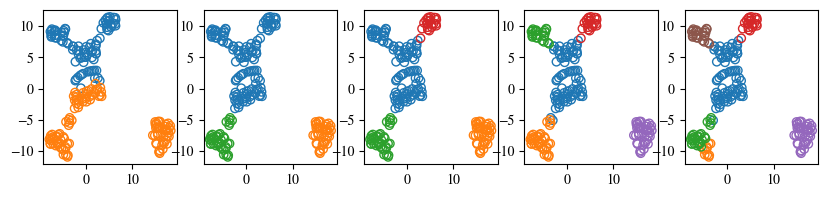

In [11]:
tsne = TSNE(n_components=2)
data_2d = tsne.fit_transform(data)
plt.figure(figsize=(10, 2))
for k in range(2, 7):
    plt.subplot(1, 5, k - 1)
    labels, centroids = kmeans(data, k, seed=i)
    for j in range(k):
        plt.scatter(data_2d[labels == j, 0], data_2d[labels == j, 1])
    print(
        f'K: {k:<4} Silhouette: {silhouette_coefficient(data, labels, centroids):.4f}'
    )
plt.show()

The silhouette coefficient achieves its maximum value at $k=5$, which is consistent with the elbow method.


### Effect of Data Distribution

$k$-means clustering prefers clusters of spherical shape (blobs) and similar size. To be specific, it works best when the data points are drawn from a mixture of Gaussian distributions with equal covariance. However, when the data structure is not spherically shaped or unevenly sized, the performance may degrade.

We use the dataset utilities in Scikit-Learn to generate various synthetic datasets with different distributions, and perform $k$-means clustering on them. Our code is based on the [official example](https://scikit-learn.org/stable/auto_examples/cluster/plot_cluster_comparison.html) in Scikit-Learn.


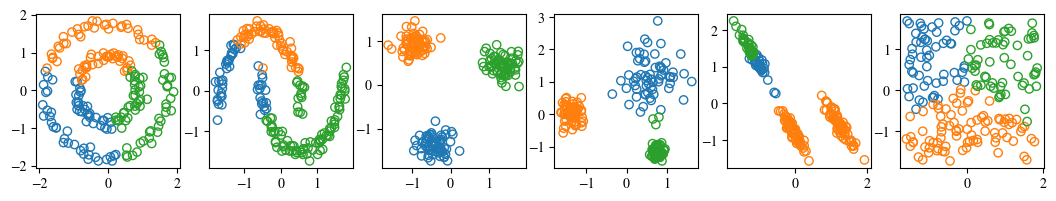

In [12]:
from sklearn.datasets import make_circles, make_moons, make_blobs
from sklearn.preprocessing import StandardScaler

np.random.seed(15)
datasets = [
    # Concentric circles
    make_circles(n_samples=200, factor=0.5, noise=0.05)[0],
    # Half moons
    make_moons(n_samples=200, noise=0.05)[0],
    # Blobs with equal variance
    make_blobs(n_samples=200)[0],
    # Blobs with different variance
    make_blobs(n_samples=200, cluster_std=[1.0, 2.5, 0.5])[0],
    # Anisotropic blobs
    np.dot(
        make_blobs(n_samples=200)[0],
        [[0.6, -0.6], [-0.4, 0.8]],
    ),
    # No structure
    np.random.rand(200, 2),
]

plt.figure(figsize=(13, 2))
for i_dataset, dataset in enumerate(datasets):
    data = StandardScaler().fit_transform(dataset)
    labels, _ = kmeans(data, 3)
    plt.subplot(1, 6, i_dataset + 1)
    for j in range(3):
        plt.scatter(data[labels == j, 0], data[labels == j, 1])

plt.show()

As can be seen, $k$-means clustering fails to well separate data points in irregular shapes.


## Conclusion

In this experiment, we implement the $k$-means clustering algorithm and apply it to 4 datasets. For the main Mall Customer Segmentation dataset, $k$-means algorithm effectively captures the underlying structure of customers' Annual Income and Spending Score, partitioning the customers into 5 clusters. We also compare our implementation with the Scikit-Learn library. The results show that our implementation is able to achieve comparable performance to the Scikit-Learn library. We also show that the running time of our implementation is linear in $n$ and $d$. Moreover, we demonstrate the effect of initialization, number of clusters and data distribution on the clustering results.
